In [527]:
import numpy as np
import matplotlib.pyplot as plt

In [528]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [529]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from pyro.nn import PyroModule, PyroSample

In [530]:
%matplotlib inline
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [531]:
# Data loaders for MNIST dataset
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=256, shuffle=False)

In [532]:
# Pyro based linear layer
class PyroLinear(PyroModule):
    def __init__(self, in_feat, out_feat, use_cuda=False):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_feat, out_feat, bias=True)

        weight_loc = torch.tensor([0.])
        weight_scale = torch.tensor([1.])
        bias_loc = torch.tensor([0.])
        bias_scale = torch.tensor([1.])
        if use_cuda:
            weight_loc = weight_loc.cuda()
            weight_scale = weight_scale.cuda()
            bias_loc = bias_loc.cuda()
            bias_scale = bias_scale.cuda()

        self.linear.weight = PyroSample(dist.Normal(weight_loc, weight_scale).expand([out_feat, in_feat]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(bias_loc, bias_scale).expand([out_feat]).to_event(1))
    
    def forward(self, x):
        return self.linear(x)


# Pyro based bayesian neural net
class BNN(PyroModule):
    def __init__(self, use_cuda=False):
        super().__init__()
        self.fc1 = PyroLinear(28 * 28, 1024, use_cuda=use_cuda)
        self.fc2 = PyroLinear(1024, 10, use_cuda=use_cuda)
    
    def forward(self, x, y=None):
        x = x.view(-1, 784)
        out = self.fc2(self.fc1(x))
        logits = F.log_softmax(out, dim=-1)
        with pyro.plate('data', x.shape[0], device=x.device):
            preds = pyro.sample('obs', dist.Categorical(logits=logits).to_event(1), obs=y)
        return logits

In [533]:
# Train for 1 epoch
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train


# Evaluate the current model on test set
def evaluate(model, guide, svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    total = 0.
    correct = 0.
    # compute the loss over the entire test set
    for x, y in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x, y)
        
        # draw samples from posterior predictive
        # to compute current accuracy
        with torch.no_grad():
            post_pred = Predictive(model, guide=guide,
                                   num_samples=10,
                                   return_sites=('obs', '_RETURN'))
            pred_samples = post_pred(x)
            pred_mean = torch.mean(pred_samples['_RETURN'], dim=0)
            total += y.size(0)
            correct += (pred_mean.argmax(dim=-1) == y).sum().item()
    acc = (correct / total) * 100
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test, acc

In [534]:
NUM_EPOCHS = 20
TEST_FREQUENCY = 2
USE_CUDA = torch.cuda.is_available()

model = BNN(use_cuda=USE_CUDA)
guide = AutoDiagonalNormal(model)
adam = Adam({'lr': 3e-4})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [535]:
pyro.clear_param_store()

train_elbo = []
test_elbo = []

# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test, acc = evaluate(model, guide, svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f test acc: %.2f" % (epoch, total_epoch_loss_test, acc))

[epoch 000]  average training loss: 8523.7005
[epoch 000] average test loss: 7204.7033 test acc: 84.44
[epoch 001]  average training loss: 6965.4271
[epoch 002]  average training loss: 6679.5917
[epoch 002] average test loss: 6723.2697 test acc: 88.98
[epoch 003]  average training loss: 6545.3954
[epoch 004]  average training loss: 6425.4658
[epoch 004] average test loss: 6497.1984 test acc: 89.98
[epoch 005]  average training loss: 6304.9233
[epoch 006]  average training loss: 6226.8963
[epoch 006] average test loss: 6293.9690 test acc: 91.04
[epoch 007]  average training loss: 6119.6426
[epoch 008]  average training loss: 6034.7155
[epoch 008] average test loss: 6103.0905 test acc: 91.63
[epoch 009]  average training loss: 5950.8363
[epoch 010]  average training loss: 5862.6224
[epoch 010] average test loss: 5937.2643 test acc: 91.73
[epoch 011]  average training loss: 5780.4665
[epoch 012]  average training loss: 5690.7411
[epoch 012] average test loss: 5760.9924 test acc: 92.04
[ep

In [ ]:
image, label = iter(train_loader).next()

In [321]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

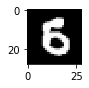

In [536]:
imshow(image[21].squeeze())

In [537]:
label[21]

tensor(5)

In [538]:
post_pred = Predictive(model, guide=guide,
                       num_samples=10,
                       return_sites=('obs', '_RETURN'))
pred_samples = post_pred(image[21].cuda())
pred_mean = torch.mean(pred_samples['_RETURN'], dim=0)
pred_std = torch.std(pred_samples['_RETURN'], dim=0)

In [539]:
F.softmax(pred_mean, dim=-1).argmax()

tensor(6, device='cuda:0')

In [540]:
pred_mean

tensor([[ -40.6440, -138.0764,  -80.9457,  -59.9982, -104.4311,  -18.4773,
          -17.3751, -175.5134,  -23.2603,  -71.6453]], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [541]:
pred_std

tensor([[13.3207, 11.6831, 21.6759, 14.1366, 17.6876, 19.6857, 19.2362, 23.1347,
         12.8538, 17.2100]], device='cuda:0', grad_fn=<StdBackward1>)